In [1]:
cd ../

/media/beast/ds-drive/github/predictive-maintenance/ml


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

%matplotlib inline

In [3]:
data_dir = 'data/dataset/'

In [4]:
telemetry = pd.read_csv(f'{data_dir}PdM_telemetry.csv')
maint = pd.read_csv(f'{data_dir}PdM_maint.csv')
machines = pd.read_csv(f'{data_dir}PdM_machines.csv')
failures = pd.read_csv(f'{data_dir}PdM_failures.csv')
errors = pd.read_csv(f'{data_dir}PdM_errors.csv')

**telemetry.csv** The first data source is the telemetry time-series data which consists of voltage, rotation, pressure and vibration measurements collected from 100 machines in real time averaged over every hour collected.

**errors.csv** The errors logs are non-breaking errors thrown while the machine is still operational and do not constitute as failures. The error date and times are rounded to the closest hour since the telemetry data is collected at an hourly rate.

**maint.csv** This file contains the scheduled and unscheduled maintenance records which correspond to both regular inspection of components as well as failures. A record is generated if a component is replaced during the scheduled inspection or replaced due to a break down. The records that are created due to break downs will be called failures which is explained in the later sections.

**machines.csv** This data set includes some information about the machines which are model type and years in service.

**failures.csv** These are the records of component replacements due to failures. Each record has a date and time, machine ID and failed component type.

## Simple Vis.

In [5]:
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [6]:
telemetry.machineID.nunique()

100

In [7]:
telemetry.dtypes

datetime      object
machineID      int64
volt         float64
rotate       float64
pressure     float64
vibration    float64
dtype: object

In [8]:
maint.head()

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


In [9]:
machines.head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [10]:
machines.machineID.nunique()

100

In [11]:
failures.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


In [12]:
errors.head()

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


In [13]:
print(telemetry.machineID.nunique())
print(maint.machineID.nunique())
print(machines.machineID.nunique())
print(failures.machineID.nunique())
print(errors.machineID.nunique())

100
100
100
98
100


## Prepare Data

In [14]:
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [15]:
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'], format="%Y-%m-%d %H:%M:%S")
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [16]:
telemetry['datetime'].min()

Timestamp('2015-01-01 06:00:00')

In [17]:
telemetry['datetime'].max()

Timestamp('2016-01-01 06:00:00')

In [18]:
telemetry.dtypes

datetime     datetime64[ns]
machineID             int64
volt                float64
rotate              float64
pressure            float64
vibration           float64
dtype: object

In [19]:
telemetry.describe()

,machineID,volt,rotate,pressure,vibration
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,170.777736,446.605119,100.858668,40.385007
std,28.866087,15.509114,52.673886,11.048679,5.370361
min,1.000000,97.333604,138.432075,51.237106,14.877054
25%,25.750000,160.304927,412.305714,93.498181,36.777299
50%,50.500000,170.607338,447.558150,100.425559,40.237247
75%,75.250000,181.004493,482.176600,107.555231,43.784938
max,100.000000,255.124717,695.020984,185.951998,76.791072


In [20]:
print(telemetry.datetime.min())
print(telemetry.datetime.max())

2015-01-01 06:00:00
2016-01-01 06:00:00


In [21]:
# errors

errors['datetime'] = pd.to_datetime(errors['datetime'], format="%Y-%m-%d %H:%M:%S")
errors['errorID'] = errors['errorID'].astype('category')

print('Total number of error records: {}'.format(len(errors)))
errors.head()

Total number of error records: 3919


,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


Text(0, 0.5, 'Count')

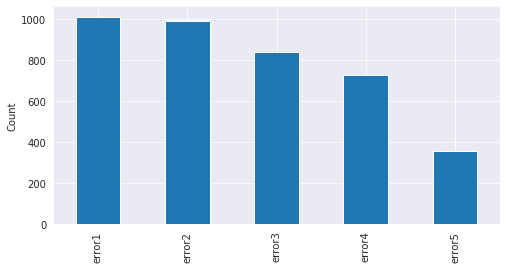

In [22]:
sns.set_style("darkgrid")
plt.figure(figsize=(8, 4))
errors['errorID'].value_counts().plot(kind='bar')
plt.ylabel('Count')

In [23]:
# maintenance

maint['datetime'] = pd.to_datetime(maint['datetime'], format="%Y-%m-%d %H:%M:%S")
maint['comp'] = maint['comp'].astype('category')

print('Total number of maintenance records: {}'.format(len(maint)))
maint.head()

Total number of maintenance records: 3286


,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


Text(0, 0.5, 'Count')

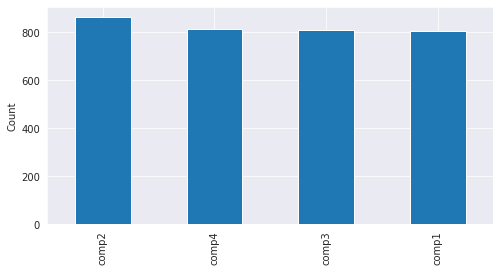

In [24]:
plt.figure(figsize=(8, 4))
maint['comp'].value_counts().plot(kind='bar')
plt.ylabel('Count')

In [25]:
# machines

machines['model'] = machines['model'].astype('category')

print('Total number of machines: {}'.format(len(machines.index)))
machines.head()

Total number of machines: 100


,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [26]:
machines.dtypes

machineID       int64
model        category
age             int64
dtype: object

In [27]:
# failures

failures['datetime'] = pd.to_datetime(failures['datetime'], format="%Y-%m-%d %H:%M:%S")
failures['failure'] = failures['failure'].astype('category')

print('Total number of failures: {}'.format(len(failures)))
failures.head()

Total number of failures: 761


,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


Text(0, 0.5, 'Count')

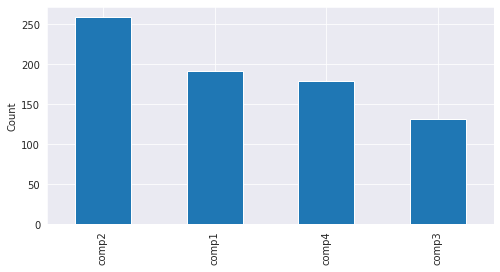

In [28]:
plt.figure(figsize=(8, 4))
failures['failure'].value_counts().plot(kind='bar')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

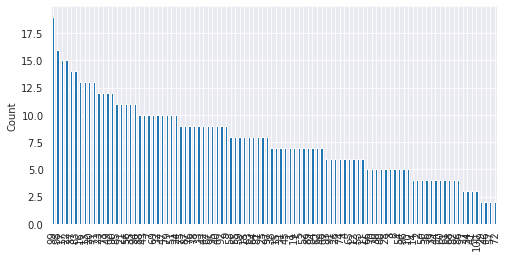

In [29]:
plt.figure(figsize=(8, 4))
failures['machineID'].value_counts().plot(kind='bar')
plt.ylabel('Count')

## Feature Engineering

In [30]:
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


### Lag features 3h period

In [31]:
telemetry[telemetry.machineID == 1].set_index('datetime').resample('3H', closed='left', label='right').mean().head(10)

,machineID,volt,rotate,pressure,vibration
datetime,,,,,
2015-01-01 09:00:00,1,170.028993,449.533798,94.592122,40.893502
2015-01-01 12:00:00,1,164.192565,403.949857,105.687417,34.255891
2015-01-01 15:00:00,1,168.134445,435.781707,107.793709,41.239405
2015-01-01 18:00:00,1,165.514453,430.472823,101.703289,40.373739
2015-01-01 21:00:00,1,168.809347,437.111120,90.911060,41.738542
2015-01-02 00:00:00,1,168.779396,486.242664,90.446472,41.796657
2015-01-02 03:00:00,1,172.277489,477.738628,89.104865,41.232001
2015-01-02 06:00:00,1,180.133784,440.608320,94.137969,41.551544
2015-01-02 09:00:00,1,176.364293,439.349655,101.553209,36.105580


In [32]:
fields = ['volt', 'rotate', 'pressure', 'vibration']

In [33]:
# 3h periods

temp = []
for m_id in telemetry.machineID.unique():
    df = telemetry[telemetry.machineID == m_id].set_index('datetime').resample(
            '3H', closed='left', label='right').mean()
    df['machineID'] = [m_id] * len(df)
    temp.append(df)
    
telemetry_mean_3h = pd.concat(temp)
telemetry_mean_3h.reset_index(inplace=True)
cstr = 'mean_3h'
telemetry_mean_3h.columns = [
    "datetime", "machineID", "volt{}".format(cstr), "rotate{}".format(cstr), 
    "pressure{}".format(cstr), "vibration{}".format(cstr)]
print(len(telemetry_mean_3h))
telemetry_mean_3h.head()

292100


,datetime,machineID,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h
0,2015-01-01 09:00:00,1,170.028993,449.533798,94.592122,40.893502
1,2015-01-01 12:00:00,1,164.192565,403.949857,105.687417,34.255891
2,2015-01-01 15:00:00,1,168.134445,435.781707,107.793709,41.239405
3,2015-01-01 18:00:00,1,165.514453,430.472823,101.703289,40.373739
4,2015-01-01 21:00:00,1,168.809347,437.111120,90.911060,41.738542


In [34]:
temp = []
for m_id in telemetry.machineID.unique():
    df = telemetry[telemetry.machineID == m_id].set_index('datetime').resample(
            '3H', closed='left', label='right').std()
    df['machineID'] = [m_id] * len(df)
    temp.append(df)
    
telemetry_std_3h = pd.concat(temp)
telemetry_std_3h.reset_index(inplace=True)
cstr = 'sd_3h'
telemetry_std_3h.columns = [
    "datetime", "machineID", "volt{}".format(cstr), "rotate{}".format(cstr), 
    "pressure{}".format(cstr), "vibration{}".format(cstr)]
print(len(telemetry_std_3h))
telemetry_std_3h.head()

292100


,datetime,machineID,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h
0,2015-01-01 09:00:00,1,6.721032,67.849599,18.934956,5.874970
1,2015-01-01 12:00:00,1,7.596570,50.120452,8.555032,7.662229
2,2015-01-01 15:00:00,1,10.124584,55.084734,5.909721,5.169304
3,2015-01-01 18:00:00,1,4.673269,42.047278,4.554047,2.106108
4,2015-01-01 21:00:00,1,14.752132,47.048609,4.244158,2.207884


In [35]:
# 24h periods

telemetry[telemetry.machineID == 1].set_index('datetime').rolling(24).mean().resample(
            '3H', closed='left', label='right').first().dropna().head(10)

,machineID,volt,rotate,pressure,vibration
datetime,,,,,
2015-01-02 06:00:00,1.0,169.733809,445.179865,96.797113,40.385160
2015-01-02 09:00:00,1.0,170.614862,446.364859,96.849785,39.736826
2015-01-02 12:00:00,1.0,169.893965,447.009407,97.715600,39.498374
2015-01-02 15:00:00,1.0,171.243444,444.233563,96.666060,40.229370
2015-01-02 18:00:00,1.0,170.792486,448.440437,95.766838,40.055214
2015-01-02 21:00:00,1.0,170.556674,452.267095,98.065860,40.033247
2015-01-03 00:00:00,1.0,168.460525,451.031783,99.273286,38.903462
2015-01-03 03:00:00,1.0,169.772951,447.502464,99.005946,39.389725
2015-01-03 06:00:00,1.0,170.900562,453.864597,100.877342,38.696225


In [36]:
temp = []
for m_id in telemetry.machineID.unique():
    df = telemetry[telemetry.machineID == m_id].set_index('datetime').rolling(24).mean().resample(
            '3H', closed='left', label='right').first().dropna()
    df['machineID'] = [m_id] * len(df)
    temp.append(df)
    
telemetry_mean_24h = pd.concat(temp)
telemetry_mean_24h.reset_index(inplace=True)
cstr = 'mean_24h'
telemetry_mean_24h.columns = [
    "datetime", "machineID", "volt{}".format(cstr), "rotate{}".format(cstr), 
    "pressure{}".format(cstr), "vibration{}".format(cstr)]
print(len(telemetry_mean_24h))
telemetry_mean_24h.head()

291400


,datetime,machineID,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h
0,2015-01-02 06:00:00,1,169.733809,445.179865,96.797113,40.385160
1,2015-01-02 09:00:00,1,170.614862,446.364859,96.849785,39.736826
2,2015-01-02 12:00:00,1,169.893965,447.009407,97.715600,39.498374
3,2015-01-02 15:00:00,1,171.243444,444.233563,96.666060,40.229370
4,2015-01-02 18:00:00,1,170.792486,448.440437,95.766838,40.055214


In [37]:
temp = []
for m_id in telemetry.machineID.unique():
    df = telemetry[telemetry.machineID == m_id].set_index('datetime').rolling(24).std().resample(
            '3H', closed='left', label='right').first().dropna()
    df['machineID'] = [m_id] * len(df)
    temp.append(df)
    
telemetry_std_24h = pd.concat(temp)
telemetry_std_24h.reset_index(inplace=True)
cstr = 'sd_24h'
telemetry_std_24h.columns = [
    "datetime", "machineID", "volt{}".format(cstr), "rotate{}".format(cstr), 
    "pressure{}".format(cstr), "vibration{}".format(cstr)]
print(len(telemetry_std_24h))
telemetry_std_24h.head()

291400


,datetime,machineID,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
0,2015-01-02 06:00:00,1,11.233120,48.717395,10.079880,5.853209
1,2015-01-02 09:00:00,1,12.519402,48.385076,10.171540,6.163231
2,2015-01-02 12:00:00,1,13.370357,42.432317,9.471669,6.195076
3,2015-01-02 15:00:00,1,13.299281,41.346121,8.731229,5.687944
4,2015-01-02 18:00:00,1,13.954518,43.490234,8.061653,5.898069


In [38]:
# merge columns of feature sets created earlier
telemetry_feat = pd.concat([telemetry_mean_3h,
                            telemetry_std_3h.iloc[:, 2:6],
                            telemetry_mean_24h.iloc[:, 2:6],
                            telemetry_std_24h.iloc[:, 2:6]], axis=1).dropna()
telemetry_feat.describe()

,machineID,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
count,291301.000000,291301.000000,291301.000000,291301.000000,291301.000000,291301.000000,291301.000000,291301.000000,291301.000000,291301.000000,291301.000000,291301.000000,291301.000000,291301.000000,291301.000000,291301.000000,291301.000000
mean,50.381221,170.780318,446.602212,100.861550,40.384205,13.299403,44.453960,8.885935,4.441080,170.773548,446.611928,100.854764,40.384565,14.918960,49.948561,10.046718,5.002048
std,28.798587,9.502471,33.126940,7.417368,3.477703,6.965654,23.214588,4.656234,2.320225,4.718539,18.077387,4.734045,2.059625,2.260750,7.682497,1.713687,0.799820
min,1.000000,125.532506,211.811184,72.118639,26.569635,0.025509,0.078991,0.027417,0.015278,155.812721,266.010419,91.057429,35.060087,6.380619,18.385248,4.145308,2.144863
25%,25.000000,164.452103,427.552670,96.239742,38.147384,8.028617,26.906792,5.369928,2.684949,168.071038,441.549434,98.668637,39.354145,13.358795,44.669651,8.924373,4.460347
50%,50.000000,170.435415,448.376863,100.236331,40.145780,12.495649,41.792679,8.346061,4.173935,170.211668,449.211753,100.097585,40.072840,14.853989,49.613412,9.921518,4.958578
75%,75.000000,176.614963,468.444030,104.408517,42.227222,17.688117,59.092647,11.790087,5.899534,172.460420,456.368551,101.611001,40.833390,16.394715,54.822682,10.980529,5.484454
max,100.000000,241.420717,586.682904,162.309656,69.311324,58.444332,179.903039,35.659369,18.305595,220.782618,499.096975,152.394833,61.932124,27.664538,103.819404,28.654103,12.325783


In [39]:
telemetry_feat.head(30)

,datetime,machineID,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
0,2015-01-01 09:00:00,1,170.028993,449.533798,94.592122,40.893502,6.721032,67.849599,18.934956,5.874970,169.733809,445.179865,96.797113,40.385160,11.233120,48.717395,10.079880,5.853209
1,2015-01-01 12:00:00,1,164.192565,403.949857,105.687417,34.255891,7.596570,50.120452,8.555032,7.662229,170.614862,446.364859,96.849785,39.736826,12.519402,48.385076,10.171540,6.163231
2,2015-01-01 15:00:00,1,168.134445,435.781707,107.793709,41.239405,10.124584,55.084734,5.909721,5.169304,169.893965,447.009407,97.715600,39.498374,13.370357,42.432317,9.471669,6.195076
3,2015-01-01 18:00:00,1,165.514453,430.472823,101.703289,40.373739,4.673269,42.047278,4.554047,2.106108,171.243444,444.233563,96.666060,40.229370,13.299281,41.346121,8.731229,5.687944
4,2015-01-01 21:00:00,1,168.809347,437.111120,90.911060,41.738542,14.752132,47.048609,4.244158,2.207884,170.792486,448.440437,95.766838,40.055214,13.954518,43.490234,8.061653,5.898069
5,2015-01-02 00:00:00,1,168.779396,486.242664,90.446472,41.796657,15.901952,36.129552,4.310741,9.390494,170.556674,452.267095,98.065860,40.033247,14.402740,42.626186,10.408012,5.941890
6,2015-01-02 03:00:00,1,172.277489,477.738628,89.104865,41.232001,6.884615,46.850076,9.205122,3.019906,168.460525,451.031783,99.273286,38.903462,15.513819,40.395881,10.833294,5.737671
7,2015-01-02 06:00:00,1,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,169.772951,447.502464,99.005946,39.389725,15.726970,39.648116,11.904700,5.601191
8,2015-01-02 09:00:00,1,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,170.900562,453.864597,100.877342,38.696225,15.635083,41.828592,11.326412,5.583521
9,2015-01-02 12:00:00,1,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,169.533156,454.785072,100.050567,39.449734,13.995465,40.843882,11.036546,5.561553


## Lag Features from Errors

In [40]:
errors.head()

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


In [41]:
errors.dtypes

datetime     datetime64[ns]
machineID             int64
errorID            category
dtype: object

In [42]:
error_count = pd.get_dummies(errors)
error_count.columns = ['datetime', 'machineID', 'error1', 'error2', 'error3', 'error4', 'error5']
error_count = error_count.groupby(['machineID', 'datetime']).sum().reset_index()

error_count.head()

,machineID,datetime,error1,error2,error3,error4,error5
0,1,2015-01-03 07:00:00,1,0,0,0,0
1,1,2015-01-03 20:00:00,0,0,1,0,0
2,1,2015-01-04 06:00:00,0,0,0,0,1
3,1,2015-01-10 15:00:00,0,0,0,1,0
4,1,2015-01-22 10:00:00,0,0,0,1,0


In [43]:
error_count = telemetry[['datetime', 'machineID']].merge(error_count, on=['machineID', 'datetime'], how='left').fillna(0.0)
error_count.describe()

,machineID,error1,error2,error3,error4,error5
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,0.001153,0.001128,0.000957,0.000830,0.000406
std,28.866087,0.033934,0.033563,0.030913,0.028795,0.020154
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.750000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.500000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.250000,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [44]:
temp = []
fields = ['error%d' % i for i in range(1,6)]
for col in fields:
    temp.append(pd.pivot_table(error_count,
                               index='datetime',
                               columns='machineID',
                               values=col).rolling(window=24).sum().resample('3H',
                                                                             closed='left',
                                                                             label='right').first().unstack())
error_count = pd.concat(temp, axis=1)
error_count.columns = [i + 'count' for i in fields]
error_count.reset_index(inplace=True)
error_count = error_count.dropna()
error_count.describe()

,machineID,error1count,error2count,error3count,error4count,error5count
count,291400.00000,291400.000000,291400.000000,291400.000000,291400.000000,291400.000000
mean,50.50000,0.027649,0.027069,0.022907,0.019904,0.009753
std,28.86612,0.166273,0.164429,0.151453,0.140820,0.098797
min,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.75000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.50000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.25000,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.00000,2.000000,2.000000,2.000000,2.000000,2.000000


In [45]:
error_count.head()

,machineID,datetime,error1count,error2count,error3count,error4count,error5count
7,1,2015-01-02 06:00:00,0.0,0.0,0.0,0.0,0.0
8,1,2015-01-02 09:00:00,0.0,0.0,0.0,0.0,0.0
9,1,2015-01-02 12:00:00,0.0,0.0,0.0,0.0,0.0
10,1,2015-01-02 15:00:00,0.0,0.0,0.0,0.0,0.0
11,1,2015-01-02 18:00:00,0.0,0.0,0.0,0.0,0.0


## Days Since Last Replacement from Maintenance
Calculate how long it has been since a component is last replaced.

In [46]:
maint.head()

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


In [47]:
maint.dtypes

datetime     datetime64[ns]
machineID             int64
comp               category
dtype: object

In [48]:
# create a column for each error type
comp_rep = pd.get_dummies(maint)
comp_rep.columns = ['datetime', 'machineID', 'comp1', 'comp2', 'comp3', 'comp4']

# combine repairs for a given machine in a given hour
comp_rep = comp_rep.groupby(['machineID', 'datetime']).sum().reset_index()

# add timepoints where no components were replaced
comp_rep = telemetry[['datetime', 'machineID']].merge(comp_rep,
                                                      on=['datetime', 'machineID'],
                                                      how='outer').fillna(0).sort_values(by=['machineID', 'datetime'])

comp_rep.head()

,datetime,machineID,comp1,comp2,comp3,comp4
876100,2014-06-01 06:00:00,1,0.0,1.0,0.0,0.0
876101,2014-07-16 06:00:00,1,0.0,0.0,0.0,1.0
876102,2014-07-31 06:00:00,1,0.0,0.0,1.0,0.0
876103,2014-12-13 06:00:00,1,1.0,0.0,0.0,0.0
0,2015-01-01 06:00:00,1,0.0,0.0,0.0,0.0


In [49]:
components = ['comp1', 'comp2', 'comp3', 'comp4']
for comp in components:
    # convert indicator to most recent date of component change
    comp_rep.loc[comp_rep[comp] < 1, comp] = None
    comp_rep.loc[-comp_rep[comp].isnull(), comp] = comp_rep.loc[-comp_rep[comp].isnull(), 'datetime']
    
    # forward-fill the most-recent date of component change
    comp_rep[comp] = pd.to_datetime(comp_rep[comp].fillna(method="ffill"))
    
comp_rep.head()

,datetime,machineID,comp1,comp2,comp3,comp4
876100,2014-06-01 06:00:00,1,NaT,2014-06-01 06:00:00,NaT,NaT
876101,2014-07-16 06:00:00,1,NaT,2014-06-01 06:00:00,NaT,2014-07-16 06:00:00
876102,2014-07-31 06:00:00,1,NaT,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00
876103,2014-12-13 06:00:00,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00
0,2015-01-01 06:00:00,1,2014-12-13 06:00:00,2014-06-01 06:00:00,2014-07-31 06:00:00,2014-07-16 06:00:00


In [50]:
# remove dates in 2014 (may have NaN or future component change dates)    
comp_rep = comp_rep.loc[comp_rep['datetime'] > pd.to_datetime('2015-01-01')]
for comp in components: 
    comp_rep[comp] = (comp_rep["datetime"] - pd.to_datetime(comp_rep[comp])) / np.timedelta64(1, "D")
comp_rep.head()

,datetime,machineID,comp1,comp2,comp3,comp4
0,2015-01-01 06:00:00,1,19.000000,214.000000,154.000000,169.000000
1,2015-01-01 07:00:00,1,19.041667,214.041667,154.041667,169.041667
2,2015-01-01 08:00:00,1,19.083333,214.083333,154.083333,169.083333
3,2015-01-01 09:00:00,1,19.125000,214.125000,154.125000,169.125000
4,2015-01-01 10:00:00,1,19.166667,214.166667,154.166667,169.166667


In [51]:
comp_rep.describe()

,machineID,comp1,comp2,comp3,comp4
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,53.525185,51.540806,52.725962,53.834191
std,28.866087,62.491679,59.269254,58.873114,59.707978
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25.750000,13.291667,12.125000,13.125000,13.000000
50%,50.500000,32.791667,29.666667,32.291667,32.500000
75%,75.250000,68.708333,66.541667,67.333333,70.458333
max,100.000000,491.958333,348.958333,370.958333,394.958333


## Machine Features and Merge

In [52]:
final_feat = telemetry_feat.merge(error_count, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(comp_rep, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(machines, on=['machineID'], how='left')

print(final_feat.head(15))
final_feat.describe()

              datetime  machineID  voltmean_3h  rotatemean_3h  \
0  2015-01-01 09:00:00          1   170.028993     449.533798   
1  2015-01-01 12:00:00          1   164.192565     403.949857   
2  2015-01-01 15:00:00          1   168.134445     435.781707   
3  2015-01-01 18:00:00          1   165.514453     430.472823   
4  2015-01-01 21:00:00          1   168.809347     437.111120   
5  2015-01-02 00:00:00          1   168.779396     486.242664   
6  2015-01-02 03:00:00          1   172.277489     477.738628   
7  2015-01-02 06:00:00          1   180.133784     440.608320   
8  2015-01-02 09:00:00          1   176.364293     439.349655   
9  2015-01-02 12:00:00          1   160.384568     424.385316   
10 2015-01-02 15:00:00          1   170.472461     442.933997   
11 2015-01-02 18:00:00          1   163.263806     468.937558   
12 2015-01-02 21:00:00          1   163.278466     446.493166   
13 2015-01-03 00:00:00          1   172.191198     434.214692   
14 2015-01-03 03:00:00   

,machineID,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,...,error1count,error2count,error3count,error4count,error5count,comp1,comp2,comp3,comp4,age
count,291301.000000,291301.000000,291301.000000,291301.000000,291301.000000,291301.000000,291301.000000,291301.000000,291301.000000,291301.000000,...,290601.000000,290601.000000,290601.000000,290601.000000,290601.000000,291301.000000,291301.000000,291301.000000,291301.000000,291301.000000
mean,50.381221,170.780318,446.602212,100.861550,40.384205,13.299403,44.453960,8.885935,4.441080,170.773548,...,0.027560,0.027058,0.022846,0.019955,0.009780,53.496531,51.414018,52.685370,53.829767,11.345189
std,28.798587,9.502471,33.126940,7.417368,3.477703,6.965654,23.214588,4.656234,2.320225,4.718539,...,0.166026,0.164401,0.151266,0.140998,0.098931,62.539840,59.266808,58.913766,59.744666,5.826348
min,1.000000,125.532506,211.811184,72.118639,26.569635,0.025509,0.078991,0.027417,0.015278,155.812721,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,164.452103,427.552670,96.239742,38.147384,8.028617,26.906792,5.369928,2.684949,168.071038,...,0.000000,0.000000,0.000000,0.000000,0.000000,13.250000,12.125000,13.000000,13.000000,7.000000
50%,50.000000,170.435415,448.376863,100.236331,40.145780,12.495649,41.792679,8.346061,4.173935,170.211668,...,0.000000,0.000000,0.000000,0.000000,0.000000,32.750000,29.625000,32.125000,32.500000,12.000000
75%,75.000000,176.614963,468.444030,104.408517,42.227222,17.688117,59.092647,11.790087,5.899534,172.460420,...,0.000000,0.000000,0.000000,0.000000,0.000000,68.625000,66.125000,67.250000,70.500000,16.000000
max,100.000000,241.420717,586.682904,162.309656,69.311324,58.444332,179.903039,35.659369,18.305595,220.782618,...,2.000000,2.000000,2.000000,2.000000,2.000000,491.875000,348.875000,370.875000,394.875000,20.000000


## Labeling

In [53]:
labeled_features = final_feat.merge(failures, on=['datetime', 'machineID'], how='left')
labeled_features.head(20)

,datetime,machineID,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age,failure
0,2015-01-01 09:00:00,1,170.028993,449.533798,94.592122,40.893502,6.721032,67.849599,18.934956,5.874970,...,NaN,NaN,NaN,19.125,214.125,154.125,169.125,model3,18,NaN
1,2015-01-01 12:00:00,1,164.192565,403.949857,105.687417,34.255891,7.596570,50.120452,8.555032,7.662229,...,NaN,NaN,NaN,19.250,214.250,154.250,169.250,model3,18,NaN
2,2015-01-01 15:00:00,1,168.134445,435.781707,107.793709,41.239405,10.124584,55.084734,5.909721,5.169304,...,NaN,NaN,NaN,19.375,214.375,154.375,169.375,model3,18,NaN
3,2015-01-01 18:00:00,1,165.514453,430.472823,101.703289,40.373739,4.673269,42.047278,4.554047,2.106108,...,NaN,NaN,NaN,19.500,214.500,154.500,169.500,model3,18,NaN
4,2015-01-01 21:00:00,1,168.809347,437.111120,90.911060,41.738542,14.752132,47.048609,4.244158,2.207884,...,NaN,NaN,NaN,19.625,214.625,154.625,169.625,model3,18,NaN
5,2015-01-02 00:00:00,1,168.779396,486.242664,90.446472,41.796657,15.901952,36.129552,4.310741,9.390494,...,NaN,NaN,NaN,19.750,214.750,154.750,169.750,model3,18,NaN
6,2015-01-02 03:00:00,1,172.277489,477.738628,89.104865,41.232001,6.884615,46.850076,9.205122,3.019906,...,NaN,NaN,NaN,19.875,214.875,154.875,169.875,model3,18,NaN
7,2015-01-02 06:00:00,1,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,...,0.0,0.0,0.0,20.000,215.000,155.000,170.000,model3,18,NaN
8,2015-01-02 09:00:00,1,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,...,0.0,0.0,0.0,20.125,215.125,155.125,170.125,model3,18,NaN
9,2015-01-02 12:00:00,1,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,...,0.0,0.0,0.0,20.250,215.250,155.250,170.250,model3,18,NaN


In [54]:
labeled_features.dtypes

datetime             datetime64[ns]
machineID                     int64
voltmean_3h                 float64
rotatemean_3h               float64
pressuremean_3h             float64
vibrationmean_3h            float64
voltsd_3h                   float64
rotatesd_3h                 float64
pressuresd_3h               float64
vibrationsd_3h              float64
voltmean_24h                float64
rotatemean_24h              float64
pressuremean_24h            float64
vibrationmean_24h           float64
voltsd_24h                  float64
rotatesd_24h                float64
pressuresd_24h              float64
vibrationsd_24h             float64
error1count                 float64
error2count                 float64
error3count                 float64
error4count                 float64
error5count                 float64
comp1                       float64
comp2                       float64
comp3                       float64
comp4                       float64
model                      c

In [55]:
labeled_features = labeled_features.astype(str).fillna(method='bfill', limit=7) # fill backward up to 24h
labeled_features = labeled_features.astype(str).fillna('none')
labeled_features['failure'] = labeled_features['failure'].astype('category')
labeled_features['datetime'] = pd.to_datetime(labeled_features['datetime'])
labeled_features = labeled_features.sort_values(by='datetime')
labeled_features.head()

,datetime,machineID,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age,failure
0,2015-01-01 09:00:00,1,170.02899277275068,449.533797746434,94.59212190102262,40.893501856284736,6.721032201366223,67.8495994642516,18.93495636307687,5.874969789283376,...,nan,nan,nan,19.125,214.125,154.125,169.125,model3,18,nan
157707,2015-01-01 09:00:00,55,164.590574744031,435.40591672254703,106.76412122793313,34.866218373695,15.285462752754736,35.97715582237618,11.442077701607174,5.650108061918061,...,nan,nan,nan,199.125,4.125,79.125,199.125,model3,17,nan
242394,2015-01-01 09:00:00,84,177.16911089454334,476.60667495308195,94.23072024035685,38.78878033141267,13.218837045825156,3.5900720985270462,7.214154749775121,1.0916766095268136,...,nan,nan,nan,49.125,199.125,49.125,214.125,model3,9,nan
154787,2015-01-01 09:00:00,54,177.2221181607133,489.26195877108495,102.20569448263403,42.503149430819,21.236974296657536,51.20128109973629,10.61131013266306,1.635502795237815,...,nan,nan,nan,4.125,184.125,214.125,94.125,model2,10,nan
151867,2015-01-01 09:00:00,53,179.00260005964597,455.7677393543677,106.02100336719167,43.1898714958647,3.8857724832640654,34.19887235547064,2.7859058699042003,2.308464843312431,...,nan,nan,nan,34.125,64.125,79.125,19.125,model3,5,nan


In [56]:
model_dummies = pd.get_dummies(labeled_features["model"])
labeled_features = pd.concat([labeled_features, model_dummies], axis=1)
labeled_features.drop("model", axis=1, inplace=True)
labeled_features.head()

,datetime,machineID,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,comp1,comp2,comp3,comp4,age,failure,model1,model2,model3,model4
0,2015-01-01 09:00:00,1,170.02899277275068,449.533797746434,94.59212190102262,40.893501856284736,6.721032201366223,67.8495994642516,18.93495636307687,5.874969789283376,...,19.125,214.125,154.125,169.125,18,nan,0,0,1,0
157707,2015-01-01 09:00:00,55,164.590574744031,435.40591672254703,106.76412122793313,34.866218373695,15.285462752754736,35.97715582237618,11.442077701607174,5.650108061918061,...,199.125,4.125,79.125,199.125,17,nan,0,0,1,0
242394,2015-01-01 09:00:00,84,177.16911089454334,476.60667495308195,94.23072024035685,38.78878033141267,13.218837045825156,3.5900720985270462,7.214154749775121,1.0916766095268136,...,49.125,199.125,49.125,214.125,9,nan,0,0,1,0
154787,2015-01-01 09:00:00,54,177.2221181607133,489.26195877108495,102.20569448263403,42.503149430819,21.236974296657536,51.20128109973629,10.61131013266306,1.635502795237815,...,4.125,184.125,214.125,94.125,10,nan,0,1,0,0
151867,2015-01-01 09:00:00,53,179.00260005964597,455.7677393543677,106.02100336719167,43.1898714958647,3.8857724832640654,34.19887235547064,2.7859058699042003,2.308464843312431,...,34.125,64.125,79.125,19.125,5,nan,0,0,1,0


In [57]:
labeled_features.loc[labeled_features['failure'] == 'comp4'][:16]

,datetime,machineID,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,comp1,comp2,comp3,comp4,age,failure,model1,model2,model3,model4
239478,2015-01-02 03:00:00,83,162.983394915213,432.60673941810336,104.9468380473129,49.822664035890796,9.258537109204987,59.59029337107097,8.485868794225835,2.670708372193362,...,4.875,0.875,64.875,79.875,18,comp4,0,0,0,1
46737,2015-01-02 03:00:00,17,169.364771282953,337.7143782173743,99.6947531839716,59.073948113152106,17.513727707745666,84.89331268692102,18.349860521251834,1.3511642464926026,...,34.875,124.875,139.875,0.875,14,comp4,1,0,0,0
271604,2015-01-02 03:00:00,94,179.3729884046887,455.5563178157774,106.99279385978633,52.85977688759737,7.376515154593789,36.293015496734064,6.882594392805004,7.297007458701587,...,169.875,19.875,124.875,124.875,18,comp4,0,1,0,0
105166,2015-01-04 06:00:00,37,167.98123944800332,452.21856786535096,104.9987153750015,50.94225651941327,10.007532692219158,56.94634971878869,10.620667242167508,7.617729824125029,...,97.0,217.0,127.0,0.0,16,comp4,1,0,0,0
184020,2015-01-05 06:00:00,64,162.699832297864,437.44070661846763,117.28865976972033,49.769160543178295,20.066358069632006,17.448729075585394,5.259196189693652,9.246235007678552,...,0.0,53.0,38.0,0.0,20,comp4,0,0,1,0
31,2015-01-05 06:00:00,1,185.78270894481898,439.53128810343736,99.41365952065267,51.5580816270259,14.495663821792728,45.663743247987476,4.289211539211094,7.3303972076994,...,0.0,218.0,158.0,0.0,18,comp4,0,0,1,0
99341,2015-01-06 06:00:00,35,182.49319445066803,483.47730803353926,99.29202316442922,46.217976172094744,19.944302786330883,14.101257831413808,6.471757545398788,6.765563698670511,...,24.0,159.0,84.0,0.0,17,comp4,1,0,0,0
84761,2015-01-09 06:00:00,30,181.28331124908266,440.81053400343467,104.74962576984932,58.39219337538807,16.887106670982124,53.1918287626862,6.688561822210067,2.630648622418466,...,192.0,42.0,162.0,0.0,20,comp4,0,0,1,0
239591,2015-01-16 06:00:00,83,158.09608308592735,461.0224624430204,123.30709065572132,52.114036919678874,15.698847025894068,52.49011138029334,14.095438358539825,7.158472098479968,...,19.0,15.0,0.0,0.0,18,comp4,0,0,0,1
108190,2015-01-17 06:00:00,38,164.51756916179303,474.60202457317797,93.70832885530888,49.94889299117839,0.8702425759829188,42.760371298468016,13.645092482214743,5.23644498822065,...,95.0,185.0,50.0,0.0,15,comp4,0,0,0,1


In [58]:
labeled_features.dtypes

datetime             datetime64[ns]
machineID                    object
voltmean_3h                  object
rotatemean_3h                object
pressuremean_3h              object
vibrationmean_3h             object
voltsd_3h                    object
rotatesd_3h                  object
pressuresd_3h                object
vibrationsd_3h               object
voltmean_24h                 object
rotatemean_24h               object
pressuremean_24h             object
vibrationmean_24h            object
voltsd_24h                   object
rotatesd_24h                 object
pressuresd_24h               object
vibrationsd_24h              object
error1count                  object
error2count                  object
error3count                  object
error4count                  object
error5count                  object
comp1                        object
comp2                        object
comp3                        object
comp4                        object
age                         

In [59]:
len(labeled_features)

291343

In [60]:
labeled_features = labeled_features.dropna()

In [61]:
len(labeled_features)

291343

## Model

### Train, validation, test

In [62]:
from sklearn.preprocessing import LabelEncoder

In [63]:
le = LabelEncoder()
le.fit(labeled_features.failure)

LabelEncoder()

In [64]:
import lightgbm as lgb

# make test and training splits
threshold_dates = [[pd.to_datetime("2015-09-30 01:00:00"), pd.to_datetime("2015-10-01 01:00:00")]]

valid_size = 50000

params = {
          "objective" : "multiclass",
          "metric": "multi_logloss",
          "num_class" : 5,
          "num_leaves" : 500,
          "max_depth": -1,
          "learning_rate" : 0.01
}

test_results = []
models = []
for last_train_date, first_test_date in threshold_dates:
    # split out training and test data
    train_y = le.transform(labeled_features.loc[
        labeled_features['datetime'] < last_train_date, 'failure']).astype(np.float32)
    train_X = labeled_features.loc[labeled_features['datetime'] < last_train_date].drop(
        ['datetime', 'machineID', 'failure'], 1).values.astype(np.float32)
    test_X = labeled_features.loc[labeled_features['datetime'] > first_test_date].drop(
        ['datetime', 'machineID', 'failure'], 1).values.astype(np.float32)
    
    lgval = lgb.Dataset(train_X[:valid_size], train_y[:valid_size])
    lgtrain = lgb.Dataset(train_X[valid_size:], train_y[valid_size:])
    lgbmodel = lgb.train(
        params, lgtrain, 2000, valid_sets=[lgtrain, lgval], early_stopping_rounds=100, verbose_eval=200)
    test_result = pd.DataFrame(labeled_features.loc[labeled_features['datetime'] > first_test_date])
    test_result['predicted_failure'] = np.argmax(lgbmodel.predict(test_X), axis=1)
    test_results.append(test_result)
    models.append(lgbmodel)

Training until validation scores don't improve for 100 rounds
[200]	training's multi_logloss: 0.000677294	valid_1's multi_logloss: 0.00429526
Early stopping, best iteration is:
[219]	training's multi_logloss: 0.000597476	valid_1's multi_logloss: 0.0042872


Text(0, 0.5, 'Importance')

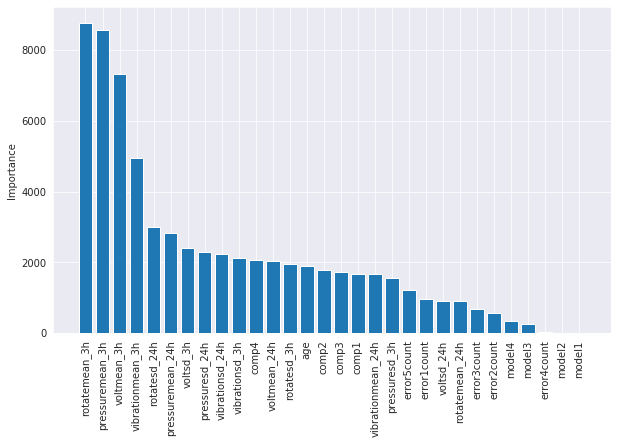

In [65]:
import operator

sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
labels, importances = zip(*sorted(zip(labeled_features.loc[labeled_features['datetime'] < last_train_date].drop(
        ['datetime', 'machineID', 'failure'], 1), models[0].feature_importance()),
                                  reverse=True,
                                  key=operator.itemgetter(1)))
plt.xticks(range(len(labels)), labels)
_, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.bar(range(len(importances)), importances)
plt.ylabel('Importance')

In [66]:
test_result['failure'] = le.transform(test_result['failure'])

In [67]:
test_result.head()

,datetime,machineID,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,comp2,comp3,comp4,age,failure,model1,model2,model3,model4,predicted_failure
180330,2015-10-01 03:00:00,62,178.23809891848066,457.414143164731,98.2597921346465,54.20711491709664,12.732673153004106,48.81941607095293,8.225083388544693,4.5971266218159474,...,20.875,80.875,5.875,20,4,0,0,0,1,4
288384,2015-10-01 03:00:00,99,171.69424940690132,411.708067485134,103.0051227964226,40.32227328074197,9.054151754609371,7.582038969826726,6.259725642522877,6.764887908229414,...,30.875,0.875,90.875,14,4,1,0,0,0,4
130686,2015-10-01 03:00:00,45,171.9172773820733,427.9061274958577,117.656280760954,52.10004395253483,9.622904014824172,50.69542188576075,6.665994237518417,4.0072741555782185,...,11.875,41.875,56.875,14,4,0,0,1,0,4
218294,2015-10-01 03:00:00,75,179.44611733616298,473.5482089252487,100.46784742762593,37.7605721291491,1.3551084271629723,39.945184214738404,20.96394310587345,2.4425909934959784,...,41.875,86.875,11.875,19,4,0,0,1,0,4
16783,2015-10-01 03:00:00,6,190.33232684132034,429.993057120052,86.32386167838168,37.8266462978476,22.080657341811058,39.20193725990697,12.410369016056377,4.772580137464906,...,71.875,11.875,56.875,7,4,0,0,1,0,4


In [68]:
from sklearn.metrics import accuracy_score, f1_score

test_result = test_results[0]
y_true = test_result['failure']
y_pred = test_result['predicted_failure']

print(accuracy_score(y_true, y_pred))
print(f1_score(y_true, y_pred, average='macro'))

0.9998358637669266
0.9531729095143666
